In [30]:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


FILEPATH = f'../data/pnl_data/AAPL.csv'
aapl_data = pd.read_csv(FILEPATH, index_col=0, parse_dates=True)
returns = aapl_data['Adj_Close'].pct_change().dropna().rename('Rets')
returns

Date
2010-01-05 00:00:00+00:00    0.001729
2010-01-06 00:00:00+00:00   -0.015906
2010-01-07 00:00:00+00:00   -0.001849
2010-01-08 00:00:00+00:00    0.006648
2010-01-11 00:00:00+00:00   -0.008821
                               ...   
2020-12-23 00:00:00+00:00   -0.006976
2020-12-24 00:00:00+00:00    0.007712
2020-12-28 00:00:00+00:00    0.035766
2020-12-29 00:00:00+00:00   -0.013315
2020-12-30 00:00:00+00:00   -0.008527
Name: Rets, Length: 2767, dtype: float64

## Conditional Sharpe Ratio
The Conditional Sharpe Ratio (CSR) is a variation of the traditional Sharpe Ratio that provides a risk-adjusted return measure specifically in downside or stressed market conditions. By focusing on conditional risk (or downside risk), it accounts for potential losses during market downturns, making it especially useful for __evaluating strategies that aim to protect against tail risks or asymmetric losses__.
</br></br>
TThe Conditional Sharpe Ratio is calculated by substituting the standard deviation in the Sharpe ratio with the Conditional Value at Risk (CVaR), which considers only the tail risk of returns below a certain threshold:

$$ Conditional\;Sharpe\;Ratio = \frac{\mathbb{E}[R-r_f]}{CVaR_{\alpha}(R)}$$

where:
* $R$ is the return of portfolio
* $r_f$ is the risk-free rate
* $\mathbb{E}[R-r_f]$ is the mean excess return
* $CVaR_{\alpha}(R)$ is the Conditional Value at Risk with confidence level $\alpha$ (e.g. 95% or 99%)


In [53]:
alpha = 0.95
method = 'parametric'
period_factor = 252

def calc_csharpe(returns, alpha=0.95, method='parametric', rfr=None, period_factor=None):
    ### 1 Find Excess Returns
    if rfr:
        rets = returns - rfr
    else:
        rets = returns.copy(deep=True)

    ### 2. Calc mean exc rets 
    mean_rets = rets.mean()
    
    ### 3. Calc VaR and CVaR
    if method == 'empirical':
        var_alpha = np.percentile(rets, 100*(1-alpha))
        cvar_alpha = rets[rets <= var_alpha].mean()

    elif method == 'parametric':
        # Calculate basic statistics
        mean_return = np.mean(rets)
        std_dev = np.std(rets)
        skewness = skew(rets)
        excess_kurtosis = kurtosis(rets)  # excess kurtosis (kurtosis - 3)
        
        # Calculate the standard normal z-score for the desired confidence level
        z_alpha = norm.ppf(1 - alpha)
        
        # Adjust the z-score using the Cornish-Fisher expansion
        z_alpha_adjusted = (
            z_alpha +
            (skewness / 6) * (z_alpha**2 - 1) +
            (excess_kurtosis / 24) * (z_alpha**3 - 3 * z_alpha) -
            (skewness**2 / 36) * (2 * z_alpha**3 - 5 * z_alpha)
        )
        
        # Parametric VaR
        var_alpha = mean_return + z_alpha_adjusted * std_dev
        
        # Parametric CVaR (Expected Shortfall)
        cvar_alpha = mean_return - (norm.pdf(z_alpha_adjusted) / (1 - alpha)) * std_dev

    # Step 4: Compute the Conditional Sharpe Ratio
    conditional_sharpe_ratio = mean_rets / -cvar_alpha  # Divide by negative CVaR to keep CSR positive

    if period_factor:
        conditional_sharpe_ratio *= np.sqrt(period_factor)
        
    return conditional_sharpe_ratio

def calc_sharpe(returns, rfr=None, period_factor=None):
    if rfr:
        rets = returns - rfr
    else:
        rets = returns.copy(deep=True)
    mean = rets.mean()
    std = rets.std()
    sharpe = mean/std
    if period_factor:
        sharpe *= np.sqrt(period_factor)
    return sharpe

### Let's compare Sharpe and CSharpe for some stocks

In [54]:
tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
data_df = pd.DataFrame()
for ticker in tickers:
    data = pd.read_csv(f'../data/stock/{ticker}.csv', index_col=0, parse_dates=True, header=0)
    data = data['Adj_Close'].pct_change().dropna().rename(ticker).to_frame()
    data_df = pd.concat([data_df, data], axis=1)
data_df

,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2010-01-05 00:00:00+00:00,0.001729,0.005900,-0.004404,0.000323
2010-01-06 00:00:00+00:00,-0.015906,-0.018116,-0.025209,-0.006137
2010-01-07 00:00:00+00:00,-0.001849,-0.017013,-0.023280,-0.010399
2010-01-08 00:00:00+00:00,0.006648,0.027077,0.013331,0.006896
2010-01-11 00:00:00+00:00,-0.008821,-0.024041,-0.001512,-0.012720
...,...,...,...,...
2020-12-23 00:00:00+00:00,-0.006976,-0.006627,0.004656,-0.013039
2020-12-24 00:00:00+00:00,0.007712,-0.003949,0.003431,0.007827
2020-12-28 00:00:00+00:00,0.035766,0.035071,0.022951,0.009921


In [74]:
metrics_df = pd.DataFrame(index = tickers, columns=['Sharpe', 'CSharpe'], dtype=float)
for ticker in tickers:
    metrics_df.loc[ticker, 'Sharpe'] = calc_sharpe(data_df[ticker], period_factor=252)
    metrics_df.loc[ticker, 'CSharpe'] = calc_csharpe(data_df[ticker], alpha=0.95, method='parametric', period_factor=252)
metrics_df = metrics_df.sort_values(by='Sharpe', ascending=False).reset_index().reset_index(names='Sharpe Ranking').sort_values(by='CSharpe', ascending=False).reset_index(names='CSharpe Ranking').set_index('index').rename_axis(index='ticker')
metrics_df[['CSharpe Ranking', 'Sharpe Ranking']] += 1
metrics_df['Sharpe Weights (Normalized)'] = metrics_df['Sharpe'] / metrics_df['Sharpe'].sum()
metrics_df['CSharpe Weights (Normalized)'] = metrics_df['CSharpe'] / metrics_df['CSharpe'].sum()
display(metrics_df)
metrics_df['CSharpe Weights (Normalized)']


,CSharpe Ranking,Sharpe Ranking,Sharpe,CSharpe,Sharpe Weights (Normalized),CSharpe Weights (Normalized)
ticker,,,,,,
AAPL,1,1,1.110466,0.478010,0.289189,0.347022
AMZN,2,2,1.076665,0.367625,0.280386,0.266886
MSFT,3,3,0.923044,0.329391,0.240380,0.239129
GOOGL,4,4,0.729756,0.202437,0.190044,0.146963


ticker
AAPL     0.347022
AMZN     0.266886
MSFT     0.239129
GOOGL    0.146963
Name: CSharpe Weights (Normalized), dtype: float64

Let's see how it performs in long-only portfolio if we weigh the stocks based on Sharpe/CSharpe score

In [86]:
sharpe_rets = (data_df @ metrics_df['Sharpe Weights (Normalized)']).rename('Sharpe Weighted')
csharpe_rets = (data_df @ metrics_df['CSharpe Weights (Normalized)']).rename('CSharpe Weighted')
wealth = (pd.concat([sharpe_rets, csharpe_rets], axis=1) +1).cumprod()
wealth

,Sharpe Weighted,CSharpe Weighted
Date,,
2010-01-05 00:00:00+00:00,1.001395,1.001605
2010-01-06 00:00:00+00:00,0.985427,0.986053
2010-01-07 00:00:00+00:00,0.973377,0.975117
2010-01-08 00:00:00+00:00,0.986718,0.987932
2010-01-11 00:00:00+00:00,0.974249,0.975344
...,...,...
2020-12-23 00:00:00+00:00,15.848577,16.715544
2020-12-24 00:00:00+00:00,15.906527,16.782376
2020-12-28 00:00:00+00:00,16.334781,17.244177


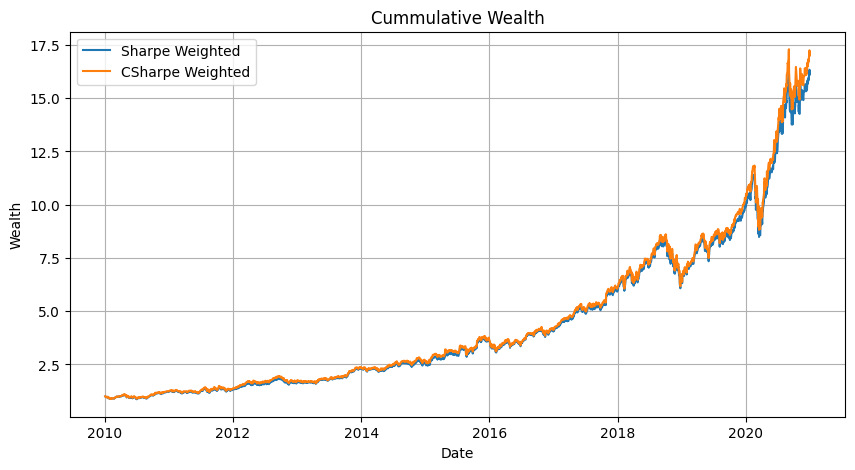

In [89]:
# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(wealth['Sharpe Weighted'], label='Sharpe Weighted')
plt.plot(wealth['CSharpe Weighted'], label='CSharpe Weighted')

# Adding labels and title
plt.title('Cummulative Wealth')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()

# Show the plot
plt.show()

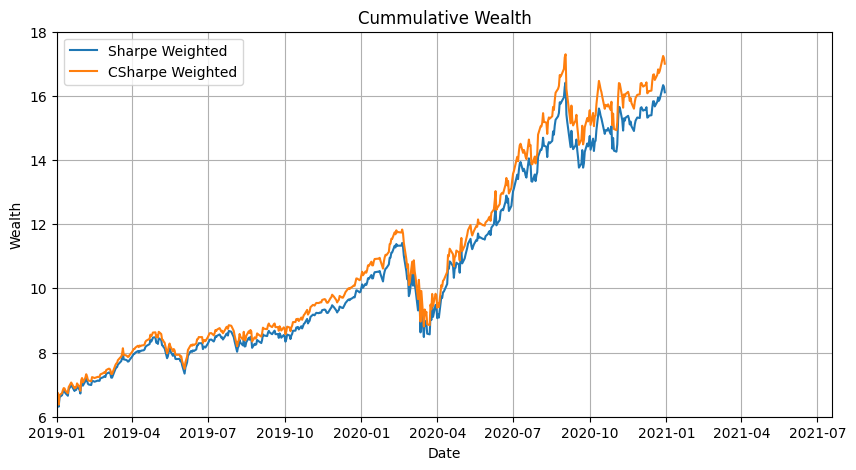

In [93]:
# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(wealth['Sharpe Weighted'], label='Sharpe Weighted')
plt.plot(wealth['CSharpe Weighted'], label='CSharpe Weighted')

# Adding labels and title
plt.title('Cummulative Wealth')
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.legend()
plt.grid()

# Zooming in on a specific part of the plot
plt.xlim(pd.Timestamp('2019'))  # Set x-axis limits
plt.ylim(6, 18)  # Set y-axis limits

# Show the plot
plt.show()